**📦 Importing Required Libraries and Dependencies**
----

In [ ]:
#pip install transformers datasets scikit-learn torchss

In [1]:
# imports for the practice (you can add more if you need)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import os
import math
from typing import Tuple

# pytorch
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

# bert & datasets

from datasets import load_dataset
from transformers import BertTokenizer
from transformers import BertForSequenceClassification

In [ ]:
!pip install --upgrade datasets fsspec

  Using cached fsspec-2025.7.0-py3-none-any.whl.metadata (12 kB)


Organizing Data
-----

In [3]:
# Loading dataset

from google.colab import drive
import os

drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/Deep_Learning/project/data"
print("Files in directory:")
for file in os.listdir(data_path):
    print(f"  '{file}'")
#df = pd.read_csv(os.path.join(data_path, 'english_lyrics.csv'))
df = pd.read_csv(os.path.join(data_path, 'english_lyrics_new.csv'))

Mounted at /content/drive
Files in directory:
  'labeled_lyrics_cleaned.csv'
  'english_lyrics.csv'
  'english_lyrics_new.csv'
  'train_finet_.csv'
  'val_finet_.csv'
  'test_finet_.csv'
  'tokenized_dataset_'


**🎵 Quantizing Valence Scores into Mood Categories**
----
This code is from an **earlier attempt** to classify song lyrics into discrete mood categories.  
In that experiment, the dataset provided **valence** as a continuous score in the range [0, 1],  
and we mapped it into **four classes** — *Sad*, *Calm*, *Content*, and *Happy* — to frame the problem as classification instead of regression.  

**Note:** This step is part of a **previous approach** and is **not needed for the current workflow**, so theres no need to run it now.

In [ ]:
# Converting float target to class ID (for classification task)
'''
NUM_CLASSES = 4

def valence_to_class(val):
    if val <= 0.25:   # sad
        return 0
    elif val <= 0.5:  # calm
        return 1
    elif val <= 0.75: # content
        return 2
    else:             # happy
        return 3


class_labels = ['Sad', 'Calm', 'Content', 'Happy']

df['class'] = df['label'].apply(valence_to_class)


#print(type(df['label'][0]))
print(df['class'].sample(50))
'''
print(df['label'].sample(50))

3857      0.5700
38954     0.0893
32524     0.7140
138455    0.4730
53519     0.6200
95361     0.5050
112696    0.3320
69068     0.3830
55679     0.2360
146428    0.3810
2739      0.3630
7012      0.2120
40943     0.0828
27723     0.2160
105717    0.1880
97884     0.4750
130138    0.8890
52130     0.1970
113100    0.4040
122251    0.6490
12201     0.1820
5452      0.8310
4232      0.9490
110936    0.3610
135685    0.5970
38393     0.9400
74378     0.5520
98728     0.3200
113911    0.8710
73086     0.8110
47400     0.8760
28790     0.3750
12800     0.3490
102907    0.3140
102440    0.4500
96234     0.3400
115076    0.0560
130740    0.6280
94800     0.8920
18994     0.4480
23231     0.3210
74595     0.5410
144480    0.5100
6175      0.1060
113642    0.2530
107990    0.7510
86668     0.6940
53771     0.3790
22229     0.2810
135493    0.8770
Name: label, dtype: float64


**Past Experiment of Creating a Balanced Subset of Data**

This code comes from an **earlier workflow** where we tried balancing the dataset  
by sampling an equal number of entries from each mood category.  
The idea was to avoid class imbalance and ensure each label was equally represented  
(5,000 samples per class in this example).  

For the **current pipeline**, the class-balancing loop above is not required.  
However, the final line that samples `df_subset` with `random_state` is **still used**  
to create a reproducible random subset of the data for training.

In [ ]:
#################################################################################################################################
######################################################### no need to run ########################################################
#################################################################################################################################

# Cutting data into balanced subset - 156K --> 20K
'''
# Number of samples per class
n_per_class = 5000

# Sample 5,000 from each class
dfs = []
for label,_ in enumerate(class_labels):
    class_subset = df[df['class'] == label].sample(n=n_per_class, random_state=42)
    dfs.append(class_subset)

# Combine and shuffle
df_balanced = pd.concat(dfs).sample(frac=1, random_state=42).reset_index(drop=True)

print(df_balanced['class'].value_counts())
print(len(df_balanced))  # Should be 30,000
'''

df_subset = df.sample(n=30000, random_state=42).reset_index(drop=True)  # set random_state for reproducibility

**📂 Train / Validation / Test Split Generation**
----
This section is responsible for splitting the dataset into **train**, **validation**, and **test** sets,  
and saving them as CSV files for later use.

This only needs to be run **once per dataset** to generate the CSV split files.  
After the CSVs are created, we can simply load them in later sections instead of re-running the split.  
The commented-out block above was for the old `df_balanced` approach,  
while the active code below works with the current `df_subset`.

In [ ]:
#################################################################################################################################
################################ no need to run, we can just load in the next section ###########################################
#################################################################################################################################

# Splitting to train, val and test
'''
df_train, df_temp = train_test_split(df_balanced, test_size=0.2, stratify=df_balanced['class'], random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp['class'], random_state=42)
# Save splits to CSV
df_train.to_csv(os.path.join(data_path, 'train_finet.csv'), index=False)
df_val.to_csv(os.path.join(data_path, 'val_finet.csv'), index=False)
df_test.to_csv(os.path.join(data_path, 'test_finet.csv'), index=False)
print(os.getcwd())
'''
df_train, df_temp = train_test_split(df_subset, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)
# Save splits to CSV
df_train.to_csv(os.path.join(data_path, 'train_finet_.csv'), index=False)
df_val.to_csv(os.path.join(data_path, 'val_finet_.csv'), index=False)
df_test.to_csv(os.path.join(data_path, 'test_finet_.csv'), index=False)
print(os.getcwd())

/content


In [ ]:
print("train_finet.csv exists:", os.path.exists(os.path.join(data_path, 'train_finet.csv')))
print("val_finet.csv exists:", os.path.exists(os.path.join(data_path, 'val_finet.csv')))

train_finet.csv exists: True
val_finet.csv exists: True


**Loading Pre-Split CSVs into Hugging Face Datasets**
----
In this step, we:  
1. **Read the pre-generated CSV files** (`train_finet.csv`, `val_finet.csv`, `test_finet.csv`) using **pandas**.  
  These CSVs were created in the earlier data-splitting stage. This avoids re-running the split logic each time we run the notebook.

2. **Convert the pandas DataFrames** into Hugging Face `Dataset` objects using `Dataset.from_pandas()`.

3. **Combine them into a `DatasetDict`** so that Hugging Face’s training and evaluation APIs  
   can directly access the `'train'`, `'validation'`, and `'test'` splits.


If you don’t have them, you must run the **Train/Val/Test Split Generation** cell first.



In [ ]:
# Load CSVs using pandas
import pandas as pd
from datasets import Dataset, DatasetDict
'''
train_df = pd.read_csv(os.path.join(data_path, 'train_finet.csv'))
val_df = pd.read_csv(os.path.join(data_path, 'val_finet.csv'))
test_df = pd.read_csv(os.path.join(data_path, 'test_finet.csv'))
'''
train_df = pd.read_csv(os.path.join(data_path, 'train_finet_.csv'))
val_df = pd.read_csv(os.path.join(data_path, 'val_finet_.csv'))
test_df = pd.read_csv(os.path.join(data_path, 'test_finet_.csv'))

# Convert to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Combine into DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

# Load tokenizer
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

These bars were fully filled after the downloads completed.  
However, before uploading the notebook to Git, we had to **remove all widget-related output metadata**.  
This was necessary because:
- GitHub cannot properly render `application/vnd.jupyter.widget-view+json` outputs (used by these progress bars).
- Such outputs can cause large, messy diffs or even prevent the notebook from displaying on GitHub.

In [ ]:
dataset['train'][0]['label']

0.494

**Tokenizing the Dataset for BERT**
----
This step takes the dataset splits (`train`, `validation`, `test`) and applies **BERT-compatible tokenization** using our previously loaded tokenizer.

There are three versions of the tokenization logic here:
1. **Basic tokenization**  Simply converts `lyrics` text into token IDs with padding/truncation.   
2. **Tokenization with chunking & index tracking (old attempt)**  Splits long lyrics into overlapping chunks, keeps track of original sample indices, and temporarily stores class labels as integers.   
3. **Final tokenization**  Keeps chunking and index tracking but directly attaches the correct label without needing a temporary column.

The final tokenized dataset is **saved to disk** (`tokenized_dataset_`) so we can load it later without re-running tokenization.

In [ ]:
#################################################################################################################################
################################ no need to run, we can just load in the next section ###########################################
#################################################################################################################################

'''
def tokenize_function(example):
    return tokenizer(example['lyrics'], padding="max_length", truncation=True)
# Tokenize both train and val sets
dataset = dataset.map(tokenize_function, batched=True)
dataset.save_to_disk(os.path.join(data_path, 'tokenized_dataset'))
'''
'''
def tokenize_with_index(examples, indices):
    tokenized = tokenizer(
        examples["lyrics"],
        truncation=True,
        max_length=512,
        stride=128,
        padding="max_length",
        return_overflowing_tokens=True,
        return_attention_mask=True,
        return_token_type_ids=True
    )

    # Add original index for each chunk
    sample_mapping = tokenized.pop("overflow_to_sample_mapping")
    tokenized["original_index"] = [indices[i] for i in sample_mapping]
    # Attach class as label - having problems with assigning to int
    tokenized["temp_label"] = [int(examples["class"][i]) for i in sample_mapping]

    return tokenized  # this is now a dict of lists

# Apply to dataset
tokenized = dataset.map(
    tokenize_with_index,
    with_indices=True,
    batched=True,
    remove_columns=['lyrics', 'artist', 'song', 'label', 'class']  # adjust as needed
)
# Drop old label if exists and re-add cleanly
tokenized = tokenized.remove_columns('label') if 'label' in tokenized['train'].column_names else tokenized

# Rename temp_label to label using map (with int)
tokenized = tokenized.map(lambda ex: {"label": int(ex["temp_label"])})
tokenized = tokenized.remove_columns("temp_label")
'''
def tokenize_with_index(examples, indices):
    tokenized = tokenizer(
        examples["lyrics"],
        truncation=True,
        max_length=512,
        stride=128,
        padding="max_length",
        return_overflowing_tokens=True,
        return_attention_mask=True,
        return_token_type_ids=True
    )

    # Add original index/label for each chunk
    sample_mapping = tokenized.pop("overflow_to_sample_mapping")
    tokenized["original_index"] = [indices[i] for i in sample_mapping]
    tokenized["label"] = [examples["label"][i] for i in sample_mapping]

    return tokenized  # this is now a dict of lists

# Apply to dataset
tokenized = dataset.map(
    tokenize_with_index,
    with_indices=True,
    batched=True,
    remove_columns=['lyrics', 'artist', 'song']  # adjust as needed
)
# Drop old label if exists and re-add cleanly
#tokenized = tokenized.remove_columns('label') if 'label' in tokenized['train'].column_names else tokenized

# Rename temp_label to label using map (with int)
#tokenized = tokenized.map(lambda ex: {"label": int(ex["temp_label"])})
#tokenized = tokenized.remove_columns("temp_label")


tokenized.save_to_disk(os.path.join(data_path, 'tokenized_dataset_'))



Map:   0%|          | 0/60000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7500 [00:00<?, ? examples/s]

Map:   0%|          | 0/7500 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/66102 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/8273 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/8257 [00:00<?, ? examples/s]

These bars were fully filled after the downloads completed.  
However, before uploading the notebook to Git, we had to **remove all widget-related output metadata**.  
This was necessary because:
- GitHub cannot properly render `application/vnd.jupyter.widget-view+json` outputs (used by these progress bars).
- Such outputs can cause large, messy diffs or even prevent the notebook from displaying on GitHub.

**Loading Tokenized Dataset & Inspecting Chunk Structure**
----
In this steps, we **load the pre-tokenized dataset** from disk (`tokenized_dataset_`) instead of re-running tokenization.  
This avoids redundant computation and ensures consistency across runs.

In [4]:
from datasets import load_from_disk
#tokenized = load_from_disk(f"{data_path}/tokenized_dataset")
tokenized = load_from_disk(f"{data_path}/tokenized_dataset_")

In [5]:
#print("Total chunks:", len(dataset['train']))
data = tokenized['train']
print(data)


Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask', 'original_index'],
    num_rows: 66102
})


In [ ]:
print("Example type:", type(data['original_index'][0]))
print("Example type:", type(data['label'][0]))
print("Example value:", data['original_index'][0])

Example type: <class 'int'>
Example type: <class 'float'>
Example value: 0


In [6]:
from collections import Counter

# Flatten original_index from list-of-list to list-of-int
flat_indices = [i[0] if isinstance(i, list) else i for i in data['original_index']]

chunk_counts = Counter(flat_indices)

print("Total lyrics:", len(set(flat_indices)))
print("Total chunks:", len(data))
print("Lyrics with >1 chunk:", sum(1 for count in chunk_counts.values() if count > 1))
print("Max chunks for a lyric:", max(chunk_counts.values()))

Total lyrics: 60000
Total chunks: 66102
Lyrics with >1 chunk: 4938
Max chunks for a lyric: 11


In [ ]:
print(type(data))

<class 'datasets.arrow_dataset.Dataset'>


In [7]:
print('Dataset type:', type(data))
print('Train columns:', data.column_names)
sample = data[0]
print('Sample type:', type(sample))
print('Sample keys:', list(sample.keys()))
print('attention_mask type:', type(sample['attention_mask']))
print('First 10 values:', sample['attention_mask'][:10])


Dataset type: <class 'datasets.arrow_dataset.Dataset'>
Train columns: ['label', 'input_ids', 'token_type_ids', 'attention_mask', 'original_index']
Sample type: <class 'dict'>
Sample keys: ['label', 'input_ids', 'token_type_ids', 'attention_mask', 'original_index']
attention_mask type: <class 'list'>
First 10 values: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


**Chunks per Input Distribution (Post-Tokenization)**
----

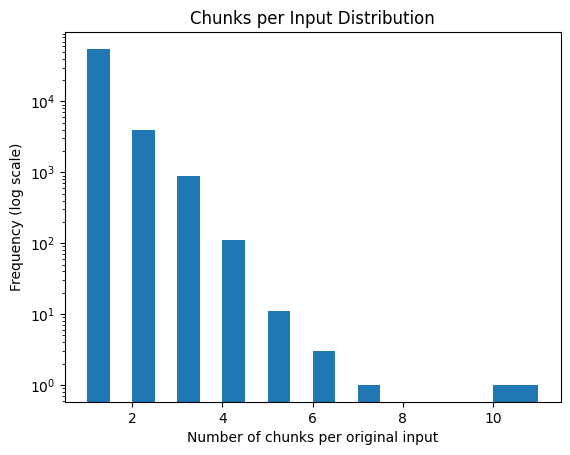

In [10]:
#dont run if you dont run the Tokenization

from collections import Counter

'''
# Attach labels to each chunk based on original_index
original_labels = dataset['train']['label']  # labels from the pre-tokenized set

def add_labels(examples):
    labels = [original_labels[idx] for idx in examples['original_index']]
    examples['label'] = labels
    return examples


tokenized = tokenized.map(add_labels, batched=True)
'''
# Flatten original_index if nested
flat_indices = [
    idx[0] if isinstance(idx, list) else idx
    for idx in tokenized['train']['original_index']
]
chunk_counts = Counter(flat_indices)

plt.hist(list(chunk_counts.values()), bins=20, log=True)
plt.xlabel("Number of chunks per original input")
plt.ylabel("Frequency (log scale)")
plt.title("Chunks per Input Distribution")
plt.show()




In [ ]:
# counting how many lyrics have each number of chunks
hist_dict = Counter(chunk_counts.values())

# Print nicely
print("Histogram of number of chunks per lyric:")
for num_chunks, count in sorted(hist_dict.items()):
    print(f"{num_chunks} chunks: {count} lyrics")

Histogram of number of chunks per lyric:
1 chunks: 55062 lyrics
2 chunks: 3936 lyrics
3 chunks: 873 lyrics
4 chunks: 112 lyrics
5 chunks: 11 lyrics
6 chunks: 3 lyrics
7 chunks: 1 lyrics
10 chunks: 1 lyrics
11 chunks: 1 lyrics


Fine-Tuning with LoRA
-----



In [ ]:
class LowRankLayer(nn.Module): # clas implementation
    def __init__(self, linear, rank, alpha, use_dora=True):
        super().__init__()
        # rank: controls the inner dimension of the matrices A and B; controls t
        # a key factor in determining the balance between model adaptability and
        # alpha: a scaling hyper-parameter applied to the output of the low-rank
        # controls the extent to which the adapted layer's output is allowed to

        self.use_dora = use_dora
        self.rank = rank # low-rank
        self.alpha = alpha # scaling hyper-parameter
        self.linear = linear
        self.in_dim = linear.in_features
        self.out_dim = linear.out_features

        # weights
        std_dev = 1 / torch.sqrt(torch.tensor(self.rank).float())
        self.A = nn.Parameter(torch.randn(self.in_dim, self.rank) * std_dev)
        self.B = nn.Parameter(torch.zeros(self.rank, self.out_dim))

        if self.use_dora:
            self.m = nn.Parameter(
                self.linear.weight.norm(p=2, dim=0, keepdim=True))
        else:
            self.m = None

    def forward(self, x):
        lora = self.A @ self.B # combine LoRA matrices
        if self.use_dora:
            numerator = self.linear.weight + self.alpha * lora.T
            denominator = numerator.norm(p=2, dim=0, keepdim=True)
            directional_component = numerator / denominator
            new_weight = self.m * directional_component
            return F.linear(x, new_weight, self.linear.bias)
        else:
            # combine LoRA with orig. weights
            combined_weight = self.linear.weight + self.alpha * lora.T
            return F.linear(x, combined_weight, self.linear.bias)

In [ ]:
def apply_lora_to_bert(model, rank, alpha, start_layer, use_dora=False,):
    """
    Apply LoRA to query and value in each transformer layer from `start_layer` to the last.

    Args:
        model: BERT model
        rank: LoRA rank
        alpha: LoRA scaling factor
        use_dora: if True, use DoRA-style adaptation
        start_layer: the index of the first encoder layer to apply LoRA (e.g. 9 means layers 9–11)
    """
    for i in range(start_layer, len(model.bert.encoder.layer)):
        layer = model.bert.encoder.layer[i]
        for proj in ['query', 'value']:
            orig = getattr(layer.attention.self, proj)

            # Only wrap if it's still a Linear layer
            if not isinstance(orig, nn.Linear):
                print(f"Skipping already-wrapped layer: layer {i} {proj}")
                continue

            wrapped = LowRankLayer(orig, rank, alpha, use_dora=use_dora)
            setattr(layer.attention.self, proj, wrapped)

In [ ]:
'''
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=NUM_CLASSES)
'''
from transformers import BertModel

class BertForRegression(nn.Module):
    def __init__(self, pretrained_model_name="bert-base-uncased"):
        super().__init__()
        self.bert = BertModel.from_pretrained(pretrained_model_name)
        self.regressor = nn.Linear(self.bert.config.hidden_size, 1)  # Output: single float

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )
        pooled_output = outputs.pooler_output
        return self.regressor(pooled_output)  # Shape: (batch_size, 1)

model = BertForRegression()
rank = 4
alpha = 8



model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

These bars were fully filled after the downloads completed.  
However, before uploading the notebook to Git, we had to **remove all widget-related output metadata**.  
This was necessary because:
- GitHub cannot properly render `application/vnd.jupyter.widget-view+json` outputs (used by these progress bars).
- Such outputs can cause large, messy diffs or even prevent the notebook from displaying on GitHub.

In [ ]:
# a original version

apply_lora_to_bert(model, rank, alpha, start_layer=9 , use_dora=False) #<------

#  Freezing all parameters except LowRankLayer and classifier
model.requires_grad_(False)


target_layers = [9, 10, 11]  # LoRA applied here
#target_layers = list(range(10, 12))  # Focus on second half layers

for name, param in model.named_parameters():
    if any(f"bert.encoder.layer.{i}.attention.self" in name for i in target_layers) and any(
        k in name for k in ['A', 'B', 'm']
    ):
        param.requires_grad = True
    elif "classifier" in name:
        param.requires_grad = True  # tuning classifier too

In [ ]:
# a original version

# Printing and collecting trainable parameters
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad:
        print("\t", name)
        params_to_update.append(param)

Params to learn:
	 bert.encoder.layer.9.attention.self.query.A
	 bert.encoder.layer.9.attention.self.query.B
	 bert.encoder.layer.9.attention.self.value.A
	 bert.encoder.layer.9.attention.self.value.B
	 bert.encoder.layer.10.attention.self.query.A
	 bert.encoder.layer.10.attention.self.query.B
	 bert.encoder.layer.10.attention.self.value.A
	 bert.encoder.layer.10.attention.self.value.B
	 bert.encoder.layer.11.attention.self.query.A
	 bert.encoder.layer.11.attention.self.query.B
	 bert.encoder.layer.11.attention.self.value.A
	 bert.encoder.layer.11.attention.self.value.B


In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)
print(tokenizer.decode(tokenized['train'][0]['input_ids']))
print(tokenized['train'][0]['label'])  # Should be int from 0 to 3


[CLS] lead me into temptation save me with your healing hands show me the fires of creation baby be my holy man flames in the garden of eden heaven in pieces at my feet i faced the raging ruin of a million sleepless nights i need to rest my weary head on your resurrection bed storms across the horizon whirlwind tuggin ' at my sleeve just when my heart was turning to an icy shade of blue you came into the night held me so close how the hell ya found me god only knows lead me into temptation save me with your healing hands show me the fires of creation baby be my holy man lies in the valley of evil like shadows fallin ' ' cross my eyes when there ' s no sanctuary you came and turned the storms away you made the darkest night in my life into judgment day lead me into temptation save me with your healing hands show me the fires of creation baby be my holy man i see forever in your eyes for your love i would make any sacrifice, yeah lead me into temptation save me with your healing hands sh

**Training Loop for BERT-Based Classification with Best Model Tracking**
----

In [ ]:
import copy

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch in dataloaders[phase]:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)


                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # zero the parameter gradients
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * input_ids.size(0)
                running_corrects += torch.sum(preds == labels)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
print(" Using existing dataset structure")
print("Columns:", tokenized['train'].column_names)

# Set format and continue with training
tokenized.set_format(
    type='torch',
    columns=['input_ids', 'attention_mask', 'label', 'original_index']
)

 Using existing dataset structure
Columns: ['label', 'input_ids', 'token_type_ids', 'attention_mask', 'original_index']


**Creating PyTorch DataLoaders for Tokenized Dataset**

In [ ]:
from torch.utils.data import DataLoader
# Defining dataloader

batch_size = 32
dataloaders = {
    'train': DataLoader(tokenized['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(tokenized['validation'], batch_size=batch_size)
}
dataset_sizes = {
    'train': len(tokenized['train']),
    'val': len(tokenized['validation'])
}

for batch in dataloaders['train']:
    print(batch['input_ids'].shape, batch['attention_mask'].shape, batch['label'])
    break

torch.Size([32, 512]) torch.Size([32, 512]) tensor([0.5620, 0.7850, 0.4010, 0.6170, 0.6530, 0.2120, 0.7210, 0.5190, 0.6440,
        0.4530, 0.1880, 0.4860, 0.3250, 0.9590, 0.6620, 0.8520, 0.6800, 0.4590,
        0.4970, 0.6600, 0.7160, 0.1360, 0.9160, 0.1800, 0.7350, 0.7410, 0.1040,
        0.0760, 0.2910, 0.6180, 0.7770, 0.5180])


**Hyperparameters**
----

In [ ]:
# Hyperparameters
from torch.optim import AdamW

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Use lower learning rate
optimizer = AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=2e-5,  # Lower learning rate
)

#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

print(f" Training setup complete:")
#print(f"   - Model output classes: {NUM_CLASSES}")
print(f"   - Model output: single float (regression)")
print(f"   - Learning rate: {optimizer.param_groups[0]['lr']}")
print(f"   - Device: {device}")
# Training
#model, hist = train_model(model, dataloaders, criterion, optimizer, num_epochs=num_epochs)

 Training setup complete:
   - Model output: single float (regression)
   - Learning rate: 2e-05
   - Device: cuda:0


**Training Loop with Lyric-Level Evaluation for Regression**
---

This code defines a custom training and evaluation pipeline for a regression task on tokenized lyric data.

**train_one_epoch()** runs one epoch for either training or validation, tracking loss and collecting predictions, labels, and original lyric indices.

**evaluate_by_lyric()** aggregates chunk-level predictions back to lyric-level by averaging, then calculates the Mean Squared Error (MSE) across complete lyrics.

**train_model_with_progress()** orchestrates multi-epoch training, evaluates after each epoch, and keeps the model state with the best validation MSE.

In [ ]:
from collections import defaultdict
import torch
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import copy


def train_one_epoch(model, dataloader, criterion, optimizer=None, device=None):
    phase = 'train' if model.training else 'val'
    running_loss = 0.0
    all_preds, all_labels, all_origins = [], [], []

    progress_bar = tqdm(dataloader, desc=f"{'  Training' if phase == 'train' else ' Validation'}", leave=False)

    for batch_idx, batch in enumerate(progress_bar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device).float()  #  ensure float32
        origins = batch['original_index']

        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs if not isinstance(outputs, torch.Tensor) else outputs
            logits = logits.view(-1)      # shape: (batch,)
            labels = labels.view(-1)      # shape: (batch,)
            loss = criterion(logits, labels)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

        batch_size = input_ids.size(0)
        running_loss += loss.item() * batch_size

        progress_bar.set_postfix({
            'Loss': f'{running_loss / ((batch_idx + 1) * batch_size):.4f}'
        })

        if phase == 'val':
            all_preds.append(logits.detach().cpu())
            all_labels.append(labels.detach().cpu())
            all_origins.extend(origins)

    epoch_loss = running_loss / len(dataloader.dataset)

    if phase == 'val':
        return epoch_loss, all_preds, all_labels, all_origins
    else:
        return epoch_loss, None  # No training accuracy anymore

def evaluate_by_lyric(all_preds, all_labels, all_origins):
    preds_cat = torch.cat(all_preds)
    labels_cat = torch.cat(all_labels)

    pred_groups = defaultdict(list)
    label_map = {}

    for pred, label, origin in zip(preds_cat, labels_cat, all_origins):
        pred_groups[origin].append(pred)
        label_map[origin] = label.item()

    preds, targets = [], []
    for origin in sorted(pred_groups.keys()):
        avg_pred = torch.stack(pred_groups[origin]).mean().item()  # direct average
        preds.append(avg_pred)
        targets.append(label_map[origin])

    # Compute regression metrics (e.g., MSE or Pearson)
    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(targets, preds)

    return mse

def train_model_with_progress(model, dataloaders, criterion, optimizer, num_epochs=25, device=None):
    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    since = time.time()
    train_loss_history = []
    val_loss_history = []
    val_mse_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_mse = float('inf')  # lower is better

    print(f" Starting training for {num_epochs} epochs...\n{'='*50}")

    for epoch in range(num_epochs):
        print(f'\n Epoch {epoch+1}/{num_epochs}\n{"-"*30}')

        # --- Training ---
        model.train()
        train_loss, _ = train_one_epoch(
            model, dataloaders['train'], criterion, optimizer, device)
        train_loss_history.append(train_loss)
        print(f"  Train      | Loss: {train_loss:.4f}")

        # --- Validation ---
        model.eval()
        val_loss, val_preds, val_labels, val_origins = train_one_epoch(
            model, dataloaders['val'], criterion, device=device)
        val_mse = evaluate_by_lyric(val_preds, val_labels, val_origins)
        val_loss_history.append(val_loss)
        val_mse_history.append(val_mse)

        print(f" Validation | Loss: {val_loss:.4f} | MSE: {val_mse:.4f}")

        # Save best model
        if val_mse < best_mse:
            best_mse = val_mse
            best_model_wts = copy.deepcopy(model.state_dict())
            print(f" New best validation MSE: {best_mse:.4f}")

        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    time_elapsed = time.time() - since
    print(f"\n Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f" Best lyric-level validation MSE: {best_mse:.4f}")

    model.load_state_dict(best_model_wts)
    history = {
        'train_loss': train_loss_history,
        'val_loss': val_loss_history,
        'val_mse': val_mse_history
    }
    return model, history

In [ ]:
print(tokenized['train'].features['label'])  # should show int64
print(type(tokenized['train'][0]['label']))  # should be <class 'int'>

Value('float64')
<class 'torch.Tensor'>


**Final Training Execution & Performance Visualization 📈**
----

 Training Configuration:
  - Epochs: 20
  - Device: cuda:0
  - Batch size: 32
  - Learning rate: 2e-05

 Starting enhanced training with progress tracking...
 Starting training for 20 epochs...

 Epoch 1/20
------------------------------


  Train      | Loss: 0.0559


 Validation | Loss: 0.0506 | MSE: 0.0506
 New best validation MSE: 0.0506

 Epoch 2/20
------------------------------


  Train      | Loss: 0.0514


 Validation | Loss: 0.0496 | MSE: 0.0496
 New best validation MSE: 0.0496

 Epoch 3/20
------------------------------


  Train      | Loss: 0.0503


 Validation | Loss: 0.0496 | MSE: 0.0496

 Epoch 4/20
------------------------------


  Train      | Loss: 0.0499


 Validation | Loss: 0.0494 | MSE: 0.0494
 New best validation MSE: 0.0494

 Epoch 5/20
------------------------------


  Train      | Loss: 0.0493


 Validation | Loss: 0.0486 | MSE: 0.0486
 New best validation MSE: 0.0486

 Epoch 6/20
------------------------------


  Train      | Loss: 0.0489


 Validation | Loss: 0.0484 | MSE: 0.0484
 New best validation MSE: 0.0484

 Epoch 7/20
------------------------------


  Train      | Loss: 0.0486


 Validation | Loss: 0.0485 | MSE: 0.0485

 Epoch 8/20
------------------------------


  Train      | Loss: 0.0481


 Validation | Loss: 0.0487 | MSE: 0.0487

 Epoch 9/20
------------------------------


  Train      | Loss: 0.0478


 Validation | Loss: 0.0489 | MSE: 0.0489

 Epoch 10/20
------------------------------


  Train      | Loss: 0.0477


 Validation | Loss: 0.0490 | MSE: 0.0490

 Epoch 11/20
------------------------------


  Train      | Loss: 0.0474


 Validation | Loss: 0.0490 | MSE: 0.0490

 Epoch 12/20
------------------------------


  Train      | Loss: 0.0471


 Validation | Loss: 0.0485 | MSE: 0.0485

 Epoch 13/20
------------------------------


  Train      | Loss: 0.0468


 Validation | Loss: 0.0491 | MSE: 0.0491

 Epoch 14/20
------------------------------


  Train      | Loss: 0.0469


 Validation | Loss: 0.0498 | MSE: 0.0498

 Epoch 15/20
------------------------------


  Train      | Loss: 0.0467


 Validation | Loss: 0.0486 | MSE: 0.0486

 Epoch 16/20
------------------------------


  Train      | Loss: 0.0466


 Validation | Loss: 0.0485 | MSE: 0.0485

 Epoch 17/20
------------------------------


  Train      | Loss: 0.0464


 Validation | Loss: 0.0483 | MSE: 0.0483
 New best validation MSE: 0.0483

 Epoch 18/20
------------------------------


  Train      | Loss: 0.0460


 Validation | Loss: 0.0483 | MSE: 0.0483
 New best validation MSE: 0.0483

 Epoch 19/20
------------------------------


  Train      | Loss: 0.0459


 Validation | Loss: 0.0483 | MSE: 0.0483

 Epoch 20/20
------------------------------


  Train      | Loss: 0.0460


 Validation | Loss: 0.0489 | MSE: 0.0489

 Training complete in 185m 51s
 Best lyric-level validation MSE: 0.0483
 Training + Validation completed successfully!
 Final Training Loss: 0.0460
 Final Validation Loss: 0.0489
 Final Validation MSE: 0.0489
 Best Validation Loss: 0.0483 (Epoch 18)
 Best Validation MSE: 0.0483 (Epoch 18)


/tmp/ipython-input-28-81315017.py:56: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-o" (-> color='g'). The keyword argument will take precedence.
  ax2.plot(epochs, val_mse, 'g-o', label='Validation MSE', linewidth=2, markersize=4, color='green')


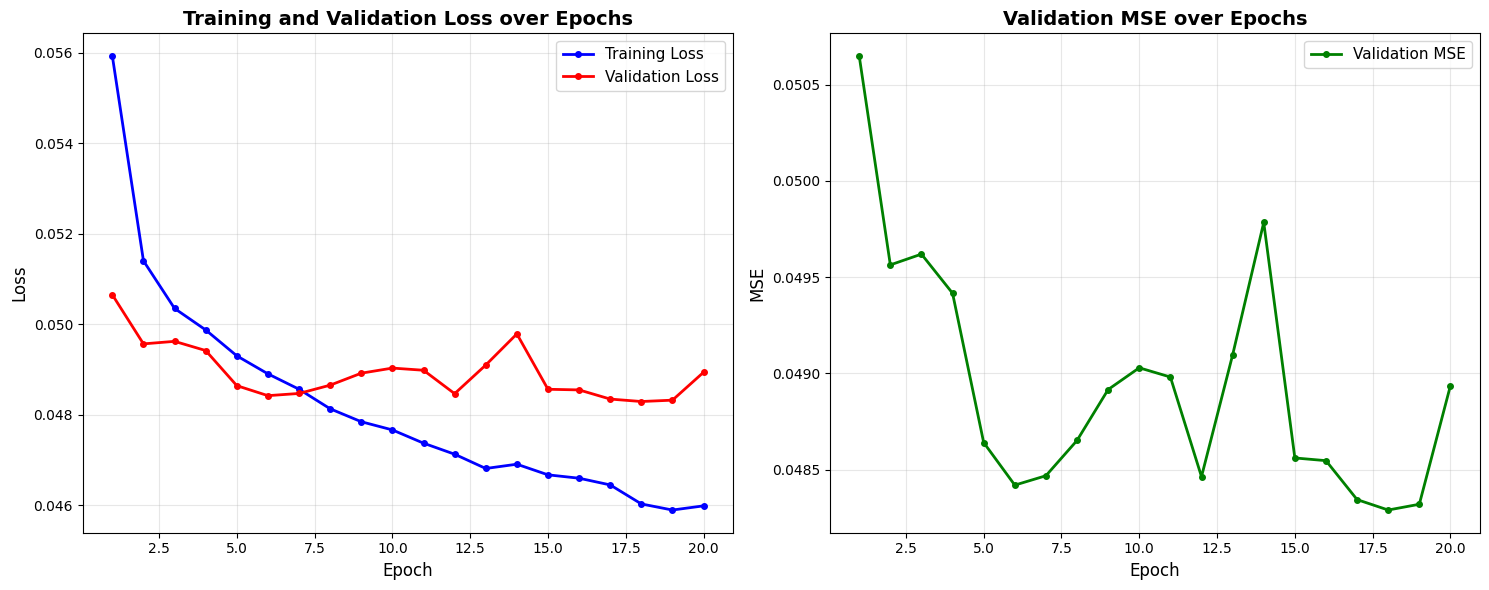

In [ ]:
#training dont run unless need
# Move model to device
model = model.to(device)

# Training configuration
num_epochs = 20

print(" Training Configuration:")
print(f"  - Epochs: {num_epochs}")
print(f"  - Device: {device}")
print(f"  - Batch size: {next(iter(dataloaders['train']))['input_ids'].shape[0]}")
print(f"  - Learning rate: {optimizer.param_groups[0]['lr']}")

# Optional: Reduce batch size if memory issues
# Uncomment the lines below if you encounter CUDA out of memory errors
"""
print("  Reducing batch size due to memory constraints...")
batch_size = 4  # Reduce from 8 to 4
dataloaders = {
    'train': DataLoader(dataset['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(dataset['validation'], batch_size=batch_size)
}
"""

# Start training with enhanced function
print("\n Starting enhanced training with progress tracking...")
model, history = train_model_with_progress(
    model=model,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device
)

print(" Training + Validation completed successfully!")

train_losses = history['train_loss']
val_losses = history['val_loss']
val_mse = history['val_mse']
epochs = list(range(1, len(train_losses) + 1))

# Create subplots for both loss and MSE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Training and Validation Loss
ax1.plot(epochs, train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=4)
ax1.plot(epochs, val_losses, 'r-o', label='Validation Loss', linewidth=2, markersize=4)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss over Epochs', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Validation MSE
ax2.plot(epochs, val_mse, 'g-o', label='Validation MSE', linewidth=2, markersize=4, color='green')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('MSE', fontsize=12)
ax2.set_title('Validation MSE over Epochs', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# Print summary statistics
print(f" Final Training Loss: {train_losses[-1]:.4f}")
print(f" Final Validation Loss: {val_losses[-1]:.4f}")
print(f" Final Validation MSE: {val_mse[-1]:.4f}")
print(f" Best Validation Loss: {min(val_losses):.4f} (Epoch {val_losses.index(min(val_losses)) + 1})")
print(f" Best Validation MSE: {min(val_mse):.4f} (Epoch {val_mse.index(min(val_mse)) + 1})")

plt.show()

In [ ]:
# Save to your existing project structure
project_path = "/content/drive/MyDrive/Deep_Learning/project/"
model_save_path = f"{project_path}saved_models/"

# Create the saved_models directory
import os
os.makedirs(model_save_path, exist_ok=True)

# Save your trained model there
torch.save(model.state_dict(), f"{model_save_path}lora_bert_emotion_model.pth")
tokenizer.save_pretrained(f"{model_save_path}lora_bert_emotion_tokenizer")

print(f" Model saved to: {model_save_path}")



 Model saved to: /content/drive/MyDrive/Deep_Learning/project/saved_models/


Model & Tokenized Data Reload for Inference
---

In [ ]:
'''
# RECREATE THE EXACT SAME MODEL STRUCTURE AS WHEN YOU SAVED IT
print(" Recreating model with LoRA structure...")

# Step 1: Create base model
model = BertForRegression()

# Step 2: Apply LoRA with the SAME parameters you used during training
rank = 4
alpha = 8
start_layer = 9  # Use the same parameters as training

apply_lora_to_bert(model, rank, alpha, start_layer, use_dora=False)

# Step 3: Set the same parameter freezing
model.requires_grad_(False)
target_layers = [9, 10, 11]  # Same as training
for name, param in model.named_parameters():
    if any(f"bert.encoder.layer.{i}.attention.self" in name for i in target_layers) and any(
        k in name for k in ['A', 'B']
    ):
        param.requires_grad = True
    elif "classifier" in name:
        param.requires_grad = True

print(" Model structure recreated with LoRA")

# Step 4: NOW load the saved weights

model_path = "/content/drive/MyDrive/Deep_Learning/project/saved_models"
model.load_state_dict(torch.load(f"{model_path}lora_bert_emotion_model.pth"))
model.eval()
'''
model_path = "/content/drive/MyDrive/Deep_Learning/project/saved_models"

# Load data
from datasets import load_from_disk
#tokenized = load_from_disk(f"{data_path}/tokenized_dataset_")
tokenized = load_from_disk(f"{data_path}/tokenized_dataset_")

tokenized['test'].set_format(
    type='torch',
    columns=['input_ids', 'attention_mask', 'label', 'original_index']
)

# Load model and apply LoRA again if needed
model = BertForRegression()
# Apply LoRA with the SAME parameters you used during training
apply_lora_to_bert(model, rank=rank, alpha=alpha, use_dora=False, start_layer=9)
model.load_state_dict(torch.load(f"{model_path}/lora_bert_emotion_model.pth"))
model = model.to(device)



**Final Model Evaluation on Test Set**
---

In [ ]:
# Testing procss

def collect_test_outputs(model, dataloader, device):
    model.eval()
    all_preds, all_labels, all_origins = [], [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="🧪 Testing", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device).float()
            origins = batch['original_index']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs if not isinstance(outputs, torch.Tensor) else outputs
            logits = logits.view(-1)
            labels = labels.view(-1)

            all_preds.append(logits.cpu())
            all_labels.append(labels.cpu())
            all_origins.extend(origins)

    return all_preds, all_labels, all_origins


test_loader = DataLoader(tokenized['test'], batch_size=batch_size)
test_preds, test_labels, test_origins = collect_test_outputs(model, test_loader, device)
test_mse = evaluate_by_lyric(test_preds, test_labels, test_origins)

print(f"\n📏 Test Lyric-Level MSE: {test_mse:.4f}")


📏 Test Lyric-Level MSE: 0.0486


**Inspecting Random Test Lyrics and Model Predictions 🎵🤖**
----

In [ ]:
# Looking at predictions
import random
import torch

# Load tokenizer
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')



def show_random_lyrics_with_predictions(model, tokenizer, dataset, device, N=3):
    model.eval()
    indices = random.sample(range(len(dataset)), N)

    for idx in indices:
        example = dataset[idx]
        input_ids = example['input_ids'].unsqueeze(0).to(device)
        attention_mask = example['attention_mask'].unsqueeze(0).to(device)
        label = example['label']
        origin = example['original_index']

        with torch.no_grad():
            output = model(input_ids=input_ids, attention_mask=attention_mask)
            pred = output.view(-1).item()

        decoded = tokenizer.decode(example['input_ids'], skip_special_tokens=True)

        print(f"\n🎵 Lyric (original_index={origin}):")
        print(decoded.strip())
        print(f"🔢 Prediction: {pred:.4f} | 🎯 Label: {label:.4f}")

show_random_lyrics_with_predictions(
    model=model,
    tokenizer=tokenizer,
    dataset=tokenized['test'],
    device=device,
    N=3  # or any number of examples you want to view
)


🎵 Lyric (original_index=1913):
i wish i knew someone like you could love me i wish i knew you place no one above me did i mistake this for a real romance? i wish i knew, but only you can answer. if you don ' t care, why let me hop [ e and pray so don ' t lead me on, if i ' m a fool just say so, should i keep dreaming on, or just forget you? what shall i do, i wish i knew
🔢 Prediction: 0.3496 | 🎯 Label: 0.8160

🎵 Lyric (original_index=678):
your mercy found me upon the broken road and lifted me beyond my failing, into your glory my sin and shame dissolved and now forever yours i? ll stand in love never to end to call you more than lord glorious friend so i throw my life upon all you are? cause i know you gave it all for me and when all else fades, my soul will dance with you where the love lasts forever and forever i will sing lord forever i will sing of how you gave your life away just to save me, lord you saved me with you, where the love lasts forever
🔢 Prediction: 0.2641 | 🎯 Label: